# Example of Tucker Riemaniannian optimization 

In [103]:
# we have to set env variable to use propack, if we want to use sparse2tuck
import os
os.environ["SCIPY_USE_PROPACK"] = "1"
import torch
import numpy as np
import tucker_riemopt
from tucker_riemopt import backend as back
from tucker_riemopt import set_backend
from tucker_riemopt.tucker.tucker import Tucker
import tucker_riemopt.tucker.riemannian as riemann
from scipy.special import expit
from tqdm import tqdm

###### Basic working tensors 
* $\text{Omega_dense} \approx I(0,1) $ is dense mask tensor 
* $\text{Omega_tucker}$ is Tucker representation of mask tensor
* $\text{X_dense} \approx R(0,1)$ is first target tensor approximation (dense tensor)
* $\text{X_tucker}$ is Tucker representation of first approximation

###### Examples of target tensors
* $\text{Sin_dense}(i_1,\ldots,i_d) = sin(i_1 + \ldots + i_d)$ is 2-rank target tensor 
* $\text{Sin_tucker}$ is Tucker representation of Sinus tensor
* $\text{Hilbert_dense}(i_1,\ldots,i_d) = \frac{1}{i_1 + \ldots + i_d + d}$ is target tensor with exponentially decaying singular numbers
* $\text{Hilbert_tucker}$ is Tucker representation of Hilbert tensor

In [34]:
#init tensors and mask
size = 128
set_backend("pytorch")

Sin_dense     = back.zeros([size,size,size])
# Hilbert_dense = back.zeros([size,size,size])
Omega_dense   = back.zeros([size,size,size])
X_dense       = back.zeros([size,size,size])

for i in range(size):
    for j in range(size):
        for k in range(size):
            Sin_dense[i][j][k]     = np.sin(i + j + k)
#             Hilbert_dense[i][j][k] = 1 / (i + j + k + 3)
            Omega_dense[i][j][k]   = 1 if np.random.uniform() < 0.01 else 0
            X_dense[i][j][k]       = np.random.uniform()

Omega_tucker = Tucker.from_dense(Omega_dense)
Sin_tucker   = Tucker.from_dense(Sin_dense)
X_tucker     = Tucker.from_dense(X_dense)

In [214]:
def Omega_projection(dense_tensor, Omega = Omega_dense):
    #Projection onto known tensor elements, given by dense Omega tensor
    #elementwise product
    return dense_tensor * Omega

def Tucker_Omega_projection(tucker_tensor, Omega = Omega_tucker):
    #Projection tensor given by tucker-format onto known tensor elements, given by dense Omega tensor
    #elementwise product in Tucker format
    return Tucker.from_dense(Omega_projection(tucker_tensor.to_dense()))

def Euclidean_grad(X, Target_tensor = Sin_tucker):
    return Tucker_Omega_projection(Target_tensor) - Tucker_Omega_projection(X)

def f(X, A = Sin_tucker):
    return 1/2 * (Tucker_Omega_projection(A) - Tucker_Omega_projection(X)).norm() ** 2

def line_search(eta, X):
    proj_eta = Tucker_Omega_projection(eta)
    return proj_eta.flat_inner(Euclidean_grad(X)) / (proj_eta.norm() ** 2)

def retraction(X, xi, r):
    return (X + xi).round([r, r, r])


In [4]:
xi,fx    = riemann.grad(f, X_tucker)
xi       = xi.construct()
eta      = -xi
alpha    = line_search(eta, X_tucker)
X_tucker = retraction(X_tucker, alpha * eta, 2)

In [5]:
max_iter = 150

for k in range(max_iter):
    betta = 1/(xi).norm()
    xi,fx = riemann.grad(f, X_tucker)
    xi = xi.construct()
    betta *=(xi).norm()
    eta   = -xi + betta*riemann.project(X_tucker, eta).construct()
    alpha = line_search(eta, X_tucker)
    X_tucker     = retraction(X_tucker, alpha*eta, 2)
    eps = back.sqrt(2*fx) / Sin_tucker.norm()
    
    if k%50 ==0:
        print(round(float(eps),5))
    if eps <1e-2:
        break

0.12124
0.08936
0.08711


In [6]:
print("Relative error: ||A-X||/||A|| ",round(float((Sin_dense - X_tucker.to_dense()).norm()/Sin_dense.norm()),5))

Relative error: ||A-X||/||A||  1.16606


## FB15-237 dataset

In [104]:
#Датасет качать отсюда ->  https://www.kaggle.com/datasets/huihuixu/fb15k-237
class Data:
    def __init__(self, data_dir="data/", reverse=False):
        self.train_data = self.load_data(data_dir, "train", reverse=reverse)
        self.valid_data = self.load_data(data_dir, "valid", reverse=reverse)
        self.test_data = self.load_data(data_dir, "test", reverse=reverse)
        self.data = self.train_data + self.valid_data + self.test_data
        self.entities = self.get_entities(self.data)
        self.train_relations = self.get_relations(self.train_data)
        self.valid_relations = self.get_relations(self.valid_data)
        self.test_relations = self.get_relations(self.test_data)
        self.relations = self.train_relations + [i for i in self.valid_relations \
                if i not in self.train_relations] + [i for i in self.test_relations \
                if i not in self.train_relations]
        self.entity_idxs = {self.entities[i]:i for i in range(len(self.entities))}
        self.relation_idxs = { self.relations[i]:i for i in range(len( self.relations))}
        
    def load_data(self, data_dir, data_type="train", reverse=False):
        with open("%s%s.txt" % (data_dir, data_type), "r") as f:
            data = f.read().strip().split("\n")
            data = [i.split() for i in data]
            if reverse:
                data += [[i[2], i[1]+"_reverse", i[0]] for i in data]
        return data

    def get_relations(self, data):
        relations = sorted(list(set([d[1] for d in data])))
        return relations

    def get_entities(self, data):
        entities = sorted(list(set([d[0] for d in data]+[d[2] for d in data])))
        return entities
    
    def get_data_idxs(self, data):
        data_idxs = [(self.entity_idxs[data[i][0]], self.relation_idxs[data[i][1]], \
                      self.entity_idxs[data[i][2]]) for i in range(len(data))]
        return data_idxs
    
    def get_tensor(self,data):
        idxs = self.get_data_idxs(data)
        N = len(self.entities)
        Rel = len(self.train_relations)
        Tensor = np.zeros([N,Rel,N], dtype =np.int8)
        for idx in idxs:
            Tensor[idx] = 1
        return Tensor

In [144]:
#usage example
data = Data() #load data
# A = data.get_tensor(data.train_data) #get train tensor
idxs = data.get_data_idxs(data.train_data) #get train tensor indicies
idxs  = list(filter(lambda x: x[0]<=2000 and x[2]<=2000,idxs))
# A[idxs[1245]] #check correct values

## LOGLOSS FUCTIONAL

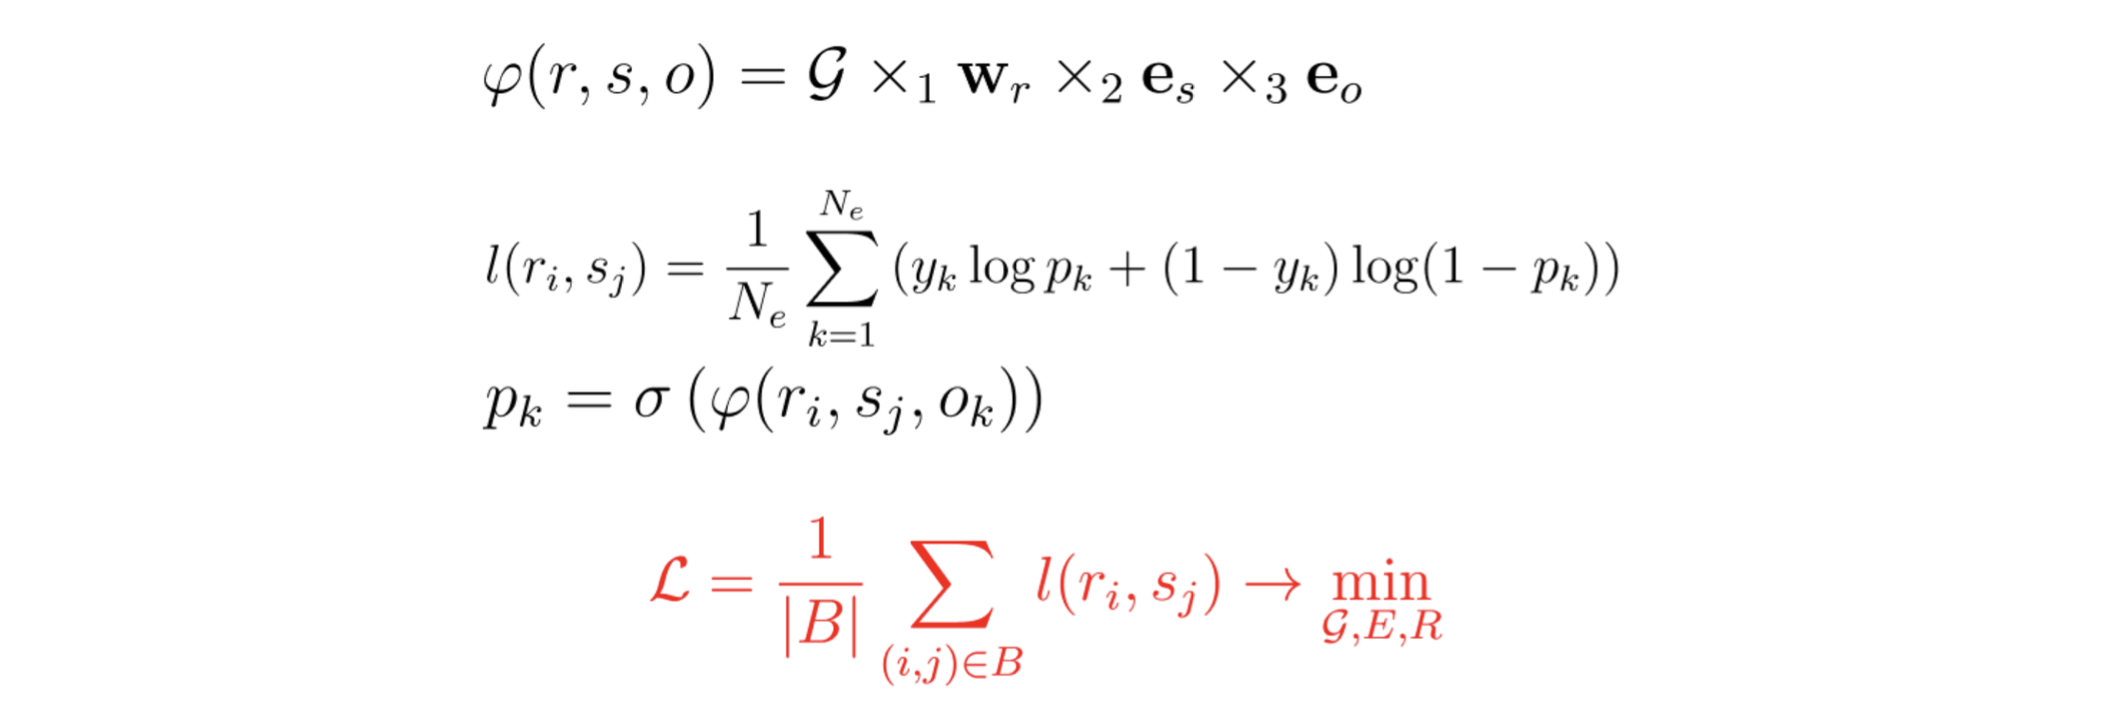

In [271]:
N = 2000

def sigmoid(x):
#     y = x.detach().numpy()
    return 1/(1+torch.exp(-x))
#for k
def p(Tucker_tensor,i,j,k):
    return expit(Sin_tucker[i,j,k])

#for whole row along index k 
def p(Tucker_tensor,i,j):
    G = Tucker_tensor.core
    U,V,W = Tucker_tensor.factors
    return sigmoid(back.einsum("ijk,i,j,nk->n", G, U[i],V[j], W))

def l(Tucker_tensor,y, i,j):
    res = 0
    y = torch.tensor(y)
    tolerance = 1
    N = Tucker_tensor.shape[-1]
    _p = p(Tucker_tensor,i,j)
    return -1/N*(y*torch.log(_p + tolerance) + (1-y)*torch.log(1-_p + tolerance)).sum()

def get_y(idxs,i,j):
    res = np.zeros(N, dtype = np.int8)
    ones = list(filter(lambda x: x[0]==i and x[1]==j ,idxs))
    if ones !=[]:
        ones = np.array(ones)[:, 2]
        for pos in ones:
            res[pos] = 1
    return res

def L(Tucker_tensor,idxs=idxs):
#     N1,N2 = Tucker_tensor.shape[0],Tucker_tensor.shape[1]
    I = np.array(idxs)[:,0:2]
    B = len(I)
    res = 0
    for i,j in tqdm(I):
#         print(i)
#         for j in range(N2):
        res+=l(Tucker_tensor,get_y(idxs,i,j), i,j)
    return res/B

def crossentropy(X, idxs=idxs):
    res = 0.0
    I = np.array(idxs)[:,0:2]
    for i,j in tqdm(I):
        y = torch.tensor(get_y(idxs,i,j), dtype = torch.float)
        tolerance = 1e-4
        res -= y @ torch.log((p(X,i,j) + tolerance)) + (1 - y) @ torch.log(1 - p(X, i, j) + tolerance)
    return res / X.shape[2] / len(I)

In [242]:
# N = 7001
Rel = len(data.train_relations)

In [292]:
G = torch.zeros((20,10 , 20))+1#back.randn((20,10,20))
# U,V = back.randn((N, 20)),back.randn((Rel, 10))
U,V  = torch.zeros((N, 20))+1 , torch.zeros((N, 10))+1
X = Tucker(G,[U,V,U])

In [293]:
crossentropy(X, idxs)

100%|█████████████████████████████████████| 5379/5379 [00:03<00:00, 1664.65it/s]


tensor(9.1779)

In [294]:
def line_search(eta, X):
    proj_eta = Tucker_Omega_projection(eta)
    return proj_eta.flat_inner(Euclidean_grad(X)) / (proj_eta.norm() ** 2)

In [295]:
xi,fx    = riemann.grad(crossentropy, X)
xi       = xi.construct()


100%|█████████████████████████████████████| 5379/5379 [00:04<00:00, 1340.70it/s]


RuntimeError: torch.linalg.lu_factor: U[2,2] is zero and using it on lu_solve would result in a division by zero. If you still want to perform the factorization, consider calling linalg.lu(A, pivot) or linalg.lu_factor_ex(A, pivot)

In [233]:
retraction(X, xi,[200,10,200])

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

## applied projection to each rank 

In [36]:
def get_triplet(core,v1,v2,v3, r1,r2,r3,Omega):
    return core[r1][r2][r3]*back.einsum("ijk,i,j,k->ijk",Omega, v1[:,r1],v2[:,r2],v3[:,r3])
def proj(tucker_tensor,R1,R2,R3, Omega=Omega_dense):
    res = back.zeros(tucker_tensor.shape)
    for r1 in range(R1):
        for r2 in range(R2):
            for r3 in range(R3):
                res += get_triplet(tucker_tensor.core,*tucker_tensor.factors, r1, r2, r3, Omega_dense)
    return Tucker.from_dense(res)

In [44]:
%time _=Tucker_Omega_projection(Sin_tucker)

CPU times: user 6.17 s, sys: 1.06 s, total: 7.23 s
Wall time: 975 ms


In [45]:
%time _=proj(Sin_tucker,2,2,2)

CPU times: user 6.91 s, sys: 1.76 s, total: 8.67 s
Wall time: 1.2 s


## Create list of sparse matrix

In [208]:
#Tried to use sparseTensor, but get bad results
three = []
size = 128
nnz = 300
Omega =back.zeros([size,size,size],dtype=int)
for i in range(nnz):
    three.append(tuple(np.random.randint(0, size,(3))))
    Omega[three[-1][0]][three[-1][1]][three[-1][2]]=1

In [209]:
def sp_pr(Sin_dense, three):    
    ZERO = back.zeros(Sin_dense.shape)
    vals = []
    for ind in three:
        ZERO[ind[0]][ind[1]][ind[2]] = Sin_dense[ind[0]][ind[1]][ind[2]]
        vals.append(Sin_dense[ind[0]][ind[1]][ind[2]])
    return ZERO, vals

In [270]:
def q(three,sparse_dense):
#     sparse_tensor = tucker_riemopt.SparseTensor([128,128,128],np.array(three).T,vals)
    sparse_tensor = tucker_riemopt.SparseTensor.dense2sparse(sparse_dense)
    r=Tucker.sparse2tuck(sparse_tensor,[128,128,128])
    return r

In [271]:
sparse_dense, vals=sp_pr(Sin_dense, three)

In [272]:
%time tensor = q(three,sparse_dense)

CPU times: user 1min 7s, sys: 10.7 s, total: 1min 18s
Wall time: 19.3 s


In [164]:
#made just for fun
def hadamard_product(t1,t2):
    core = back.kron(t1.core, t2.core)
    factor0 = back.khatri_rao([t1.factors[0], t2.factors[0]]).T
    factor1 = back.khatri_rao([t1.factors[1], t2.factors[1]]).T
    factor2 = back.khatri_rao([t1.factors[2], t2.factors[2]]).T
    return Tucker(core, [factor0,factor1,factor2])